In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Khai báo các hàm cần thiết

In [2]:
def xu_ly_mot_anh(image):
    """Tách nền của quả xoài và trả về ảnh với nền đen."""
    if image is None: return None
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green_yellow = np.array([20, 40, 40]); upper_green_yellow = np.array([90, 255, 255])
    mask_green_yellow = cv2.inRange(hsv_image, lower_green_yellow, upper_green_yellow)
    lower_red1 = np.array([10, 40, 40]); upper_red1 = np.array([15, 255, 255])
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    lower_red2 = np.array([170, 40, 40]); upper_red2 = np.array([180, 255, 255])
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    full_mask = cv2.bitwise_or(mask_green_yellow, cv2.bitwise_or(mask_red1, mask_red2))
    kernel = np.ones((7, 7), np.uint8)
    full_mask = cv2.morphologyEx(full_mask, cv2.MORPH_CLOSE, kernel)
    full_mask = cv2.morphologyEx(full_mask, cv2.MORPH_OPEN, kernel)
    return cv2.bitwise_and(image, image, mask=full_mask)

In [4]:
def tinh_ratio_green(image_path):
    """Tính toán ratio_green cho một ảnh từ đường dẫn."""
    original_image = cv2.imread(image_path)
    if original_image is None: return -1
    processed_image = xu_ly_mot_anh(original_image)
    non_black_pixels = np.any(processed_image != [0, 0, 0], axis=-1)
    if np.sum(non_black_pixels) == 0: return 0
    g_channel = processed_image[non_black_pixels, 1]
    r_channel = processed_image[non_black_pixels, 2]
    b_channel = processed_image[non_black_pixels, 0]
    tong_g = np.sum(g_channel); tong_r = np.sum(r_channel); tong_b = np.sum(b_channel)
    tong_rgb = tong_r + tong_g + tong_b
    return 0 if tong_rgb == 0 else tong_g / tong_rgb

In [ ]:
"""print(tinh_ratio_green('data/5.png'))"""

0.37395750882750056


In [ ]:
"""processed_image = xu_ly_mot_anh( cv2.imread('data/5.png'))
cv2.imwrite('ket_qua_don.jpg', processed_image)
print("Đã xử lý và lưu ảnh thành công với tên 'ket_qua_don.jpg'")"""

Đã xử lý và lưu ảnh thành công với tên 'ket_qua_don.jpg'


In [132]:
def train_mot_lan(folder_train_song, folder_train_chin):
    """
    Train trên một tập train cụ thể để tìm ngưỡng tốt nhất cho lần đó.
    """
    features = []
    # Đọc dữ liệu xoài sống
    if os.path.exists(folder_train_song):
        for f in os.listdir(folder_train_song):
            ratio = tinh_ratio_green(os.path.join(folder_train_song, f))
            if ratio != -1: features.append({'ratio': ratio, 'label': 1}) # 1 = Sống
    
    # Đọc dữ liệu xoài chín
    if os.path.exists(folder_train_chin):
        for f in os.listdir(folder_train_chin):
            ratio = tinh_ratio_green(os.path.join(folder_train_chin, f))
            if ratio != -1: features.append({'ratio': ratio, 'label': 0}) # 0 = Chín

    if not features: return 0.4 # Trả về ngưỡng mặc định nếu không có dữ liệu train

    # Tìm ngưỡng tốt nhất
    best_threshold, best_accuracy = 0, 0
    for threshold_candidate in np.arange(0.01, 1.0, 0.01):
        correct = sum(1 for item in features if (1 if item['ratio'] > threshold_candidate else 0) == item['label'])
        accuracy = correct / len(features)
        if accuracy >= best_accuracy:
            best_accuracy, best_threshold = accuracy, threshold_candidate
    return best_threshold

In [133]:

def tim_nguong_toi_uu_tong_the(danh_sach_ket_qua):
    """
    Từ kết quả của 22 lần test, tìm ra 1 ngưỡng tổng thể tốt nhất.
    """
    best_threshold, best_accuracy = 0, 0
    for threshold_candidate in np.arange(0.01, 1.0, 0.01):
        correct = sum(1 for item in danh_sach_ket_qua if (1 if item['ratio'] > threshold_candidate else 0) == item['label_thuc_te'])
        accuracy = correct / len(danh_sach_ket_qua)
        if accuracy >= best_accuracy:
            best_accuracy, best_threshold = accuracy, threshold_candidate
            
    return best_threshold, best_accuracy

# Vẽ đồ thị (biểu diễn dữ liệu trên không gian đặc trưng)

Đang xử lý ảnh trong 'Dothi\Song'...
  - 10.png: ratio = 0.4059
  - 11.png: ratio = 0.4304
  - 12.png: ratio = 0.4598
  - 13.png: ratio = 0.4442
  - 14.png: ratio = 0.4038
  - 15.png: ratio = 0.4265
  - 16.png: ratio = 0.4076
  - 17.png: ratio = 0.3923
  - 18.png: ratio = 0.4187

Đang xử lý ảnh trong 'Dothi\Chin'...
  - 1.jpg: ratio = 0.4015
  - 19.png: ratio = 0.3122
  - 2.jpg: ratio = 0.3458
  - 20.png: ratio = 0.3187
  - 21.png: ratio = 0.3780
  - 22.png: ratio = 0.3894
  - 3.png: ratio = 0.3708
  - 4.png: ratio = 0.3775
  - 5.png: ratio = 0.3740
  - 6.png: ratio = 0.3831
  - 7.png: ratio = 0.3722
  - 8.png: ratio = 0.3250
  - 9.png: ratio = 0.2337

Đang vẽ đồ thị...


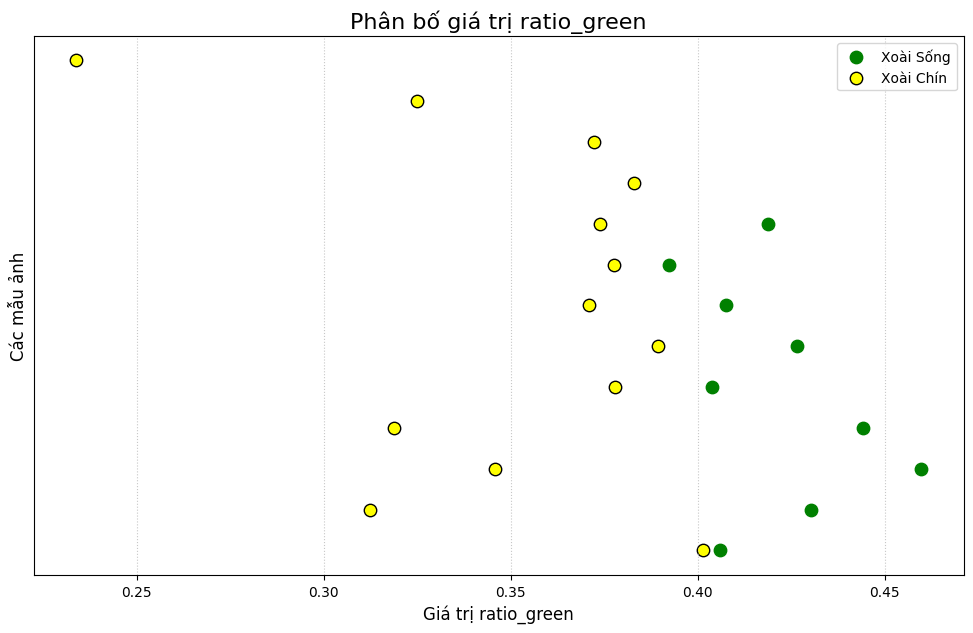

In [134]:
def ve_do_thi_tu_folder(base_folder='Dothi'):
    """
    Vẽ đồ thị phân bố ratio_green từ các ảnh trong thư mục Dothi/Song và Dothi/Chin.
    """
    path_song = os.path.join(base_folder, 'Song')
    path_chin = os.path.join(base_folder, 'Chin')

    ratios_song = []
    ratios_chin = []

    # 1. Tính ratio cho các ảnh xoài sống
    print(f"Đang xử lý ảnh trong '{path_song}'...")
    if os.path.exists(path_song):
        for filename in os.listdir(path_song):
            img_path = os.path.join(path_song, filename)
            ratio = tinh_ratio_green(img_path)
            if ratio != -1:
                ratios_song.append(ratio)
                print(f"  - {filename}: ratio = {ratio:.4f}")
    else:
        print(f"Cảnh báo: Không tìm thấy thư mục '{path_song}'")

    # 2. Tính ratio cho các ảnh xoài chín
    print(f"\nĐang xử lý ảnh trong '{path_chin}'...")
    if os.path.exists(path_chin):
        for filename in os.listdir(path_chin):
            img_path = os.path.join(path_chin, filename)
            ratio = tinh_ratio_green(img_path)
            if ratio != -1:
                ratios_chin.append(ratio)
                print(f"  - {filename}: ratio = {ratio:.4f}")
    else:
        print(f"Cảnh báo: Không tìm thấy thư mục '{path_chin}'")

    # 3. Vẽ đồ thị
    print("\nĐang vẽ đồ thị...")
    plt.figure(figsize=(12, 7))

    # Vẽ các chấm xanh lá cho xoài sống
    plt.scatter(ratios_song, range(len(ratios_song)), c='green', s=80, label='Xoài Sống')

    # Vẽ các chấm vàng cho xoài chín
    plt.scatter(ratios_chin, range(len(ratios_chin)), c='yellow', s=80, edgecolors='black', label='Xoài Chín')

    # Tùy chỉnh đồ thị
    plt.title('Phân bố giá trị ratio_green', fontsize=16)
    plt.xlabel('Giá trị ratio_green', fontsize=12)
    plt.ylabel('Các mẫu ảnh', fontsize=12)
    plt.yticks([])  # Ẩn nhãn trục y
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    
    # Hiển thị đồ thị
    plt.show()

# --- ĐOẠN MÃ ĐỂ CHẠY ---
if __name__ == '__main__':
    dothi_folder = 'Dothi'
    if not os.path.exists(dothi_folder):
        print(f"Lỗi: Thư mục '{dothi_folder}' không tồn tại.")
        print("Vui lòng tạo thư mục 'Dothi/Song' và 'Dothi/Chin' và đặt ảnh vào đó.")
    else:
        ve_do_thi_tu_folder(dothi_folder)

# Huấn luyện mô hình (huấn luyện và test để tìm ngưỡng tối ưu)

In [135]:
# --- QUY TRÌNH CHÍNH ---
if __name__ == '__main__':
    BASE_DIR = '.' # Thư mục hiện tại, nơi chứa các folder Lan_1, Lan_2...
    TOTAL_RUNS = 22
    ket_qua_cross_validation = [] # Lưu kết quả của 22 lần test

    for i in range(1, TOTAL_RUNS + 1):
        lan_folder = f"Chiafolder/Lan_{i}"
        print(f"\n===== BẮT ĐẦU LẦN {i}/{TOTAL_RUNS} =====")

        # 1. TRAIN: Tìm ngưỡng trên tập train của lần này
        path_train_song = os.path.join(BASE_DIR, lan_folder, "Train", "Song")
        path_train_chin = os.path.join(BASE_DIR, lan_folder, "Train", "Chin")
        
        print(f"-> Training trên dữ liệu của '{lan_folder}/Train'...")
        nguong_lan_nay = train_mot_lan(path_train_song, path_train_chin)
        print(f"-> Ngưỡng tìm được cho lần này: {nguong_lan_nay:.2f}")

        # 2. TEST: Dự đoán trên ảnh test của lần này
        path_test_song = os.path.join(BASE_DIR, lan_folder, "Test", "Song")
        path_test_chin = os.path.join(BASE_DIR, lan_folder, "Test", "Chin")
        
        # Tìm ảnh test và nhãn thực tế của nó
        anh_test_path, label_thuc_te = None, -1
        if os.path.exists(path_test_song) and os.listdir(path_test_song):
            ten_anh = os.listdir(path_test_song)[0]
            anh_test_path = os.path.join(path_test_song, ten_anh)
            label_thuc_te = 1 # Sống
        elif os.path.exists(path_test_chin) and os.listdir(path_test_chin):
            ten_anh = os.listdir(path_test_chin)[0]
            anh_test_path = os.path.join(path_test_chin, ten_anh)
            label_thuc_te = 0 # Chín

        if anh_test_path:
            # Tính ratio_green và dự đoán
            ratio_test = tinh_ratio_green(anh_test_path)
            du_doan = 1 if ratio_test > nguong_lan_nay else 0
            
            # So sánh và in kết quả
            ket_qua_dung_sai = "ĐÚNG" if du_doan == label_thuc_te else "SAI"
            str_label_thuc_te = "Sống" if label_thuc_te == 1 else "Chín"
            str_du_doan = "Sống" if du_doan == 1 else "Chín"
            print(f"-> Testing ảnh '{ten_anh}':")
            print(f"   - Nhãn thực tế: {str_label_thuc_te}")
            print(f"   - Tỉ lệ Green: {ratio_test:.4f}")
            print(f"   - Dự đoán: {str_du_doan}  =>  KẾT QUẢ: {ket_qua_dung_sai}")
            
            # Lưu lại kết quả để phân tích cuối cùng
            ket_qua_cross_validation.append({
                'lan': i,
                'ratio': ratio_test,
                'label_thuc_te': label_thuc_te
            })
        else:
            print(f"-> Cảnh báo: Không tìm thấy ảnh test trong '{lan_folder}/Test'")

    # 3. TỔNG KẾT: Tìm ngưỡng tốt nhất dựa trên tất cả kết quả test
    print("\n" + "="*50)
    print("      TỔNG KẾT SAU 22 LẦN CROSS-VALIDATION")
    print("="*50)

    if ket_qua_cross_validation:
        nguong_cuoi_cung, do_chinh_xac_cuoi_cung = tim_nguong_toi_uu_tong_the(ket_qua_cross_validation)
        
        print("\nPhân tích trên toàn bộ 22 ảnh test:")
        print(f"NGƯỠNG PHÂN LOẠI TỐI ƯU CUỐI CÙNG: {nguong_cuoi_cung:.2f}")
        print(f"ĐỘ CHÍNH XÁC TỔNG THỂ CỦA MÔ HÌNH: {do_chinh_xac_cuoi_cung * 100:.2f}%")
        so_anh_dung = int(do_chinh_xac_cuoi_cung * len(ket_qua_cross_validation))
        print(f"   (Dự đoán đúng {so_anh_dung}/{len(ket_qua_cross_validation)} ảnh test)")
    else:
        print("Không có kết quả nào để tổng kết.")


===== BẮT ĐẦU LẦN 1/22 =====
-> Training trên dữ liệu của 'Chiafolder/Lan_1/Train'...
-> Ngưỡng tìm được cho lần này: 0.39
-> Testing ảnh '1.jpg':
   - Nhãn thực tế: Chín
   - Tỉ lệ Green: 0.4015
   - Dự đoán: Sống  =>  KẾT QUẢ: SAI

===== BẮT ĐẦU LẦN 2/22 =====
-> Training trên dữ liệu của 'Chiafolder/Lan_2/Train'...
-> Ngưỡng tìm được cho lần này: 0.39
-> Testing ảnh '2.jpg':
   - Nhãn thực tế: Chín
   - Tỉ lệ Green: 0.3458
   - Dự đoán: Chín  =>  KẾT QUẢ: ĐÚNG

===== BẮT ĐẦU LẦN 3/22 =====
-> Training trên dữ liệu của 'Chiafolder/Lan_3/Train'...
-> Ngưỡng tìm được cho lần này: 0.39
-> Testing ảnh '3.png':
   - Nhãn thực tế: Chín
   - Tỉ lệ Green: 0.3708
   - Dự đoán: Chín  =>  KẾT QUẢ: ĐÚNG

===== BẮT ĐẦU LẦN 4/22 =====
-> Training trên dữ liệu của 'Chiafolder/Lan_4/Train'...
-> Ngưỡng tìm được cho lần này: 0.39
-> Testing ảnh '4.png':
   - Nhãn thực tế: Chín
   - Tỉ lệ Green: 0.3775
   - Dự đoán: Chín  =>  KẾT QUẢ: ĐÚNG

===== BẮT ĐẦU LẦN 5/22 =====
-> Training trên dữ liệu của 'C

In [136]:
print(nguong_cuoi_cung)

0.39


# Kiểm tra và đánh giá mô hình

BẮT ĐẦU ĐÁNH GIÁ TRÊN TẬP 'anhTest' VỚI NGƯỠNG = 0.39
- Ảnh '150554102665240-xoai.jpg' (Sống): ratio=0.4277 -> Dự đoán: Sống => ĐÚNG
- Ảnh 'e97c91fc-1-8.png' (Sống): ratio=0.4349 -> Dự đoán: Sống => ĐÚNG
- Ảnh 'xoai-bao-nhieu-calo-3.jpeg' (Sống): ratio=0.4331 -> Dự đoán: Sống => ĐÚNG
- Ảnh '472869-xoai.png' (Chín): ratio=0.3701 -> Dự đoán: Chín => ĐÚNG
- Ảnh 'pngtree-fruit-mango-hd-photography-material-image_1028736.jpg' (Chín): ratio=0.3832 -> Dự đoán: Chín => ĐÚNG

Đang vẽ đồ thị tổng hợp...


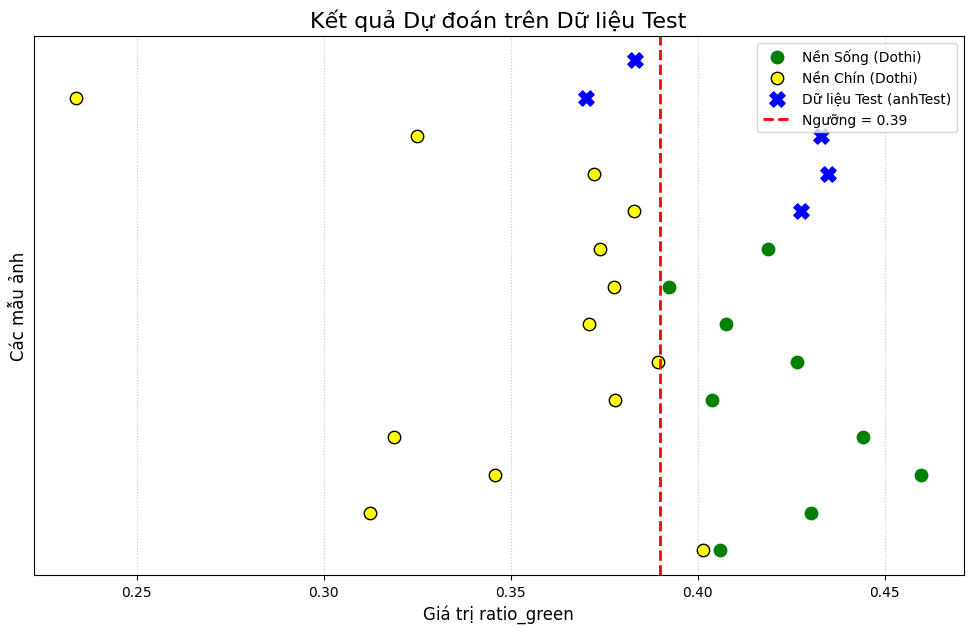

In [137]:
def danh_gia_anh_test(folder_test, nguong):
    """
    Đọc ảnh từ folder_test, tính toán, dự đoán và nhận xét.
    Trả về danh sách các ratio đã tính được.
    """
    print("="*50)
    print(f"BẮT ĐẦU ĐÁNH GIÁ TRÊN TẬP 'anhTest' VỚI NGƯỠNG = {nguong}")
    print("="*50)
    
    ratios_ket_qua = []
    path_song = os.path.join(folder_test, 'Song')
    path_chin = os.path.join(folder_test, 'Chin')

    # Xử lý ảnh xoài sống
    if os.path.exists(path_song):
        for filename in os.listdir(path_song):
            img_path = os.path.join(path_song, filename)
            ratio = tinh_ratio_green(img_path)
            if ratio == -1: continue
            
            ratios_ket_qua.append(ratio)
            du_doan = 1 if ratio > nguong else 0 # 1=Sống, 0=Chín
            nhan_xet = "ĐÚNG" if du_doan == 1 else "SAI"
            print(f"- Ảnh '{filename}' (Sống): ratio={ratio:.4f} -> Dự đoán: Sống => {nhan_xet}")

    # Xử lý ảnh xoài chín
    if os.path.exists(path_chin):
        for filename in os.listdir(path_chin):
            img_path = os.path.join(path_chin, filename)
            ratio = tinh_ratio_green(img_path)
            if ratio == -1: continue

            ratios_ket_qua.append(ratio)
            du_doan = 1 if ratio > nguong else 0 # 1=Sống, 0=Chín
            nhan_xet = "ĐÚNG" if du_doan == 0 else "SAI"
            print(f"- Ảnh '{filename}' (Chín): ratio={ratio:.4f} -> Dự đoán: Chín => {nhan_xet}")
            
    return ratios_ket_qua

def ve_do_thi_tong_hop(folder_dothi, ratios_test, nguong):
    """
    Hàm nâng cấp: Vẽ dữ liệu nền từ folder_dothi, sau đó vẽ thêm
    dữ liệu test và đường ngưỡng.
    """
    # 1. Lấy dữ liệu nền từ folder 'Dothi'
    path_song = os.path.join(folder_dothi, 'Song')
    path_chin = os.path.join(folder_dothi, 'Chin')
    ratios_dothi_song = [tinh_ratio_green(os.path.join(path_song, f)) for f in os.listdir(path_song)]
    ratios_dothi_chin = [tinh_ratio_green(os.path.join(path_chin, f)) for f in os.listdir(path_chin)]
    
    print("\nĐang vẽ đồ thị tổng hợp...")
    plt.figure(figsize=(12, 7))

    # 2. Vẽ dữ liệu nền
    plt.scatter(ratios_dothi_song, range(len(ratios_dothi_song)), c='green', s=80, label='Nền Sống (Dothi)')
    plt.scatter(ratios_dothi_chin, range(len(ratios_dothi_chin)), c='yellow', s=80, edgecolors='black', label='Nền Chín (Dothi)')

    # 3. Vẽ dữ liệu test mới bằng màu xanh blue và marker khác
    y_test_positions = range(len(ratios_dothi_song), len(ratios_dothi_song) + len(ratios_test))
    plt.scatter(ratios_test, y_test_positions, c='blue', marker='X', s=120, label='Dữ liệu Test (anhTest)')

    # 4. Vẽ đường ngưỡng
    plt.axvline(x=nguong, color='red', linestyle='--', linewidth=2, label=f'Ngưỡng = {nguong:.2f}')

    # Tùy chỉnh đồ thị
    plt.title('Kết quả Dự đoán trên Dữ liệu Test', fontsize=16)
    plt.xlabel('Giá trị ratio_green', fontsize=12)
    plt.ylabel('Các mẫu ảnh', fontsize=12)
    plt.yticks([])
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    
    plt.show()

# --- QUY TRÌNH CHÍNH ---
if __name__ == '__main__':
    dothi_folder = 'Dothi'
    test_folder = 'anhTest'

    # Kiểm tra sự tồn tại của các thư mục cần thiết
    if not os.path.exists(dothi_folder) or not os.path.exists(test_folder):
        print(f"Lỗi: Vui lòng đảm bảo 2 thư mục '{dothi_folder}' và '{test_folder}' tồn tại.")
    else:
        # 1. Đánh giá trên tập test và lấy kết quả ratio
        cac_ratio_test = danh_gia_anh_test(test_folder, nguong_cuoi_cung)

        # 2. Vẽ đồ thị tổng hợp
        ve_do_thi_tong_hop(dothi_folder, cac_ratio_test, nguong_cuoi_cung)